In [18]:
from SimpleHandEye.solvers import OpenCVSolver
from SimpleHandEye.interfaces.apriltag import ApriltagTracker
import pandas as pd
import numpy as np
import pinocchio as pin
import os 
import pickle

In [21]:
tag_size = 0.171
dataset_path = 'sample_datasets/eye_on_base_calibration/apr27/'
with open(os.path.join(dataset_path, 'camera_params.pkl'), 'rb') as f:
    int_params = pickle.load(f)
K = int_params['int_params']['RGB']['K']
tracker = ApriltagTracker(tag_size=tag_size, intrinsic_matrix=K)

In [22]:
poses = pd.read_csv(os.path.join(dataset_path, 'pose.csv'))
stamps = poses.loc[:,'id'].to_numpy()
trans = poses.loc[:,'x':'z'].to_numpy()
rots = poses.loc[:,'qx':'qw'].to_numpy()

In [23]:
import os
import cv2
images = os.listdir(os.path.join(dataset_path, 'rgb'))
images.sort(key=lambda x:int(x.split('.')[0]))
imgs = []
poses = []
cam_Ts_tag = []
base_Ts_ef = []
tag_corners = []
for image in images:
    stamp = int(image.split('.')[0])
    img = cv2.imread(os.path.join(dataset_path,'rgb', image))
    idx = np.where(stamps.squeeze()==stamp)[0]
    if len(idx) !=0:
        idx = idx[0]
        imgs.append(img)
        info = tracker.getPoseAndCorners(img, tag_id=0)
        cam_T_tag = info['pose']
        corners = info['corners']
        tag_corners.append(corners)
        cam_Ts_tag.append(cam_T_tag)
        R = pin.Quaternion(rots[idx,:]).matrix()
        t = trans[idx,:].reshape(3,1)
        base_T_ef = np.hstack([R,t])
        base_T_ef = np.vstack([base_T_ef, np.array([0,0,0,1])])
        base_Ts_ef.append(base_T_ef)

In [24]:
A = base_Ts_ef
B = cam_Ts_tag
solver = OpenCVSolver(type='AX=YB')
X,Y = solver.solve(A, B)

In [25]:
base_T_cam = Y

In [26]:
base_T_cam

array([[-0.46315684,  0.51939884, -0.71812992,  0.78216485],
       [ 0.86486408,  0.08783968, -0.49426138,  1.06991923],
       [-0.19363849, -0.85000531, -0.48989295,  0.32733943],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [27]:
for i in range(len(imgs)):
    print((A[i]@X@np.linalg.inv(Y@B[i]))[:3,-1])

[ 0.00855074 -0.00220176 -0.00368509]
[-0.00316314  0.0032423  -0.00392548]
[ 0.00276994 -0.00056509 -0.00029199]
[-0.00562678  0.0006145   0.00254469]
[-0.00370313  0.00249481  0.00129275]
[-0.00323506  0.00196376  0.00146268]
[ 0.00435698  0.00053202 -0.00171461]
[ 0.00443759 -0.00406027  0.00159362]
[-0.00105396 -0.00386617  0.00126706]
[-0.0006301  -0.00107713 -0.00456198]
[ 0.00204275 -0.00316191 -0.00107419]
[ 1.59215449e-03 -1.99013561e-03 -8.09272026e-05]
[-0.00849913  0.00440559 -0.008138  ]


In [28]:
c_in_tag_frame = np.array([[-tag_size/2, tag_size/2, 0, 1],
                                [ tag_size/2, tag_size/2, 0, 1],
                                [ tag_size/2, -tag_size/2, 0, 1],
                                [-tag_size/2,  -tag_size/2, 0, 1]]).T
c_in_tag_frame

array([[-0.0855,  0.0855,  0.0855, -0.0855],
       [ 0.0855,  0.0855, -0.0855, -0.0855],
       [ 0.    ,  0.    ,  0.    ,  0.    ],
       [ 1.    ,  1.    ,  1.    ,  1.    ]])

In [29]:
index = 1
c_in_pixel = np.hstack([tag_corners[index], np.ones((4,1))])

In [30]:
cam_T_tag_pred = np.linalg.inv(Y)@A[index]@X
cam_T_tag_pred

array([[ 0.81035137,  0.58564565,  0.01870344, -0.00361341],
       [-0.56649358,  0.77489606,  0.28039459, -0.38491678],
       [ 0.14971865, -0.23781352,  0.95970259,  0.92489778],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [31]:
cam_Ts_tag[index]

array([[ 0.81566343,  0.57834231,  0.01460611, -0.00658796],
       [-0.5568919 ,  0.77807048,  0.29065055, -0.38550879],
       [ 0.15673093, -0.24520705,  0.95671778,  0.92469871],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [32]:
c_in_pixel_pred = (K@cam_T_tag_pred[0:3,...])@c_in_tag_frame
c_in_pixel_pred = c_in_pixel_pred/c_in_pixel_pred[-1,:]
c_in_pixel_pred

array([[627.31736131, 725.34358304, 654.36671453, 558.66689106],
       [172.44786553, 109.80016573,  31.5539918 ,  89.32101552],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [33]:
c_in_pixel.T

array([[624.3380127 , 723.15441895, 653.06378174, 556.73083496],
       [171.40560913, 109.99990082,  31.96554947,  88.01757813],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

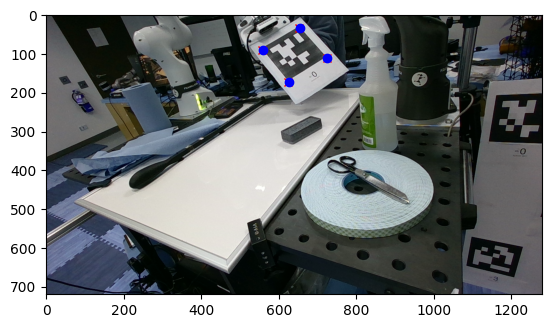

In [34]:
import matplotlib.pyplot as plt
plt.imshow(imgs[index])
plt.plot(c_in_pixel[:,0], c_in_pixel[:,1], 'rx')
plt.plot(c_in_pixel_pred.T[:,0], c_in_pixel_pred.T[:,1], 'bo')